In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf

In [2]:
train_x = np.load('exam2_train_x.npy')
train_y_original = np.load('exam2_train_y.npy')
train_y = train_y_original.astype('uint8')

test_x = np.load('exam2_test_x.npy')
test_y_original = np.load('exam2_test_y.npy')
test_y = test_y_original.astype('uint8')

print(train_x.max(),train_x.min(),test_x.max(),test_x.min())
print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)
print(test_x.shape, test_x.dtype)
print(test_y.shape, test_y.dtype)

244 3 242 8
(1020, 64, 64, 3) uint8
(1020,) uint8
(180, 64, 64, 3) uint8
(180,) uint8


y = 4


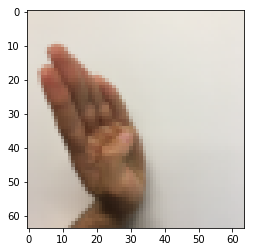

In [3]:
index = 1
plt.imshow(train_x[index])
print ("y =", train_y[index])
plt.show()

In [4]:
def one_hot_encoding(y):
    length = y.shape[0]
    output = np.zeros((6,length))      
    for i in range(length):         
        if(y[i][0]>5):  #to prevent index out of bound
            print('label is wrong');
            return -1
        else:
            output[y[i][0]][i]=1   
    return output

In [5]:
X_train = train_x/255  # mean center here??
X_test = test_x/255
Y_train = one_hot_encoding(train_y.reshape(train_y.shape[0],1)).T
Y_test = one_hot_encoding(test_y.reshape(test_y.shape[0],1)).T

print(Y_train.shape, Y_test.shape)

(1020, 6) (180, 6)


In [6]:
X_test.dtype

dtype('float64')

In [7]:
def Placeholder_Maker(h,w,c): #need size here?
    x = tf.placeholder(tf.float32, shape=[None,h,w,c], name="x_train")
    y = tf.placeholder(tf.float32, shape=[None,6], name="y_train")
    return x,y

In [8]:
X, Y = Placeholder_Maker(64,64,3)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("x_train:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("y_train:0", shape=(?, 6), dtype=float32)


In [9]:
import h5py
def save_model(para, path):
    f = h5py.File(path,'w')
    for k, v in para.items():
        f.create_dataset(k, data=v)
    f.close()

def load_model(path):
    dataset = h5py.File(path,'r')
    dataset.keys()
    para = {}
    for i in dataset.keys():
        para[i] = np.array(dataset[i])
        print(para[i].shape)
    dataset.close()
    return para

In [10]:
def initialization(seeed=0):    
    
    #change shape here
    last_dimension = [8,16,256]
#    wt = tf.get_variable('W1',[4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
                            
    w1 = tf.get_variable( name="w_1", shape=[4, 4, 3, last_dimension[0]], initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=seeed,dtype=tf.float32))
    w2 = tf.get_variable( name="w_2", shape=[2, 2, 8, last_dimension[1]], initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=seeed,dtype=tf.float32))
    w3 = tf.get_variable( name="w_3", shape=[4096, last_dimension[2]], initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=seeed,dtype=tf.float32))
    w4 = tf.get_variable( name="w_4", shape=[256, 6], initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=seeed,dtype=tf.float32))

    b1 = tf.get_variable( name="b_1", shape=[1, 1, 1, last_dimension[0]], initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=seeed,dtype=tf.float32))
    b2 = tf.get_variable( name="b_2", shape=[1, 1, 1, last_dimension[2]], initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=seeed,dtype=tf.float32))
    b3 = tf.get_variable( name="b_3", shape=[1, last_dimension[2]], initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=seeed,dtype=tf.float32))
    b4 = tf.get_variable( name="b_4", shape=[1, 6], initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=seeed,dtype=tf.float32))

    parameters = {"w1": w1,
                  "w2": w2,
                  "w3": w3,
                  "w4": w4,
                  "b1": b1,
                  "b2": b2,
                  "b3": b3,
                  "b4": b4
                 }

    return parameters    

In [11]:
def calculate_cross_entropy_loss(a,y):
    #check shape here!!!!!!!!
    #print("loss calc func shape", a.shape, "y", y.shape)
    #x = tf.constant([1.8, 2.2], dtype=tf.float32)
#     begin = i.eval()
#     end = j.eval()

    cost =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = a, labels = y))
    return cost

In [12]:
def forward_propagation_with_regularization(X, parameters):  #add reg here
    
    tf.set_random_seed(1)    
    w1 = parameters["w1"]
    w2 = parameters["w2"]
    w3 = parameters["w3"]
    w4 = parameters["w4"]
    b1 = parameters["b1"]
    b2 = parameters["b2"]
    b3 = parameters["b3"]
    b4 = parameters["b4"]
    
#     conv1 = tf.layers.conv2d(inputs=X,filters=32,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)
    l2 = tf.contrib.layers.l2_regularizer(1.0)
    
    convo1 = tf.contrib.layers.conv2d(
        inputs=X,
        num_outputs=32,
        kernel_size=3,
        stride=1,
        padding='SAME',
        activation_fn=tf.nn.relu,
        normalizer_fn=tf.contrib.layers.batch_norm,
        normalizer_params=None,
        weights_initializer=tf.contrib.layers.xavier_initializer(),
        weights_regularizer=None,
        biases_initializer=tf.zeros_initializer(),
        biases_regularizer=None,
        #trainable=True,
    )

    pool1 = tf.contrib.layers.max_pool2d(
        inputs=convo1,
        kernel_size=2,
        stride=2,
        padding='SAME',
    )
    #pool =
    convo2 = tf.contrib.layers.conv2d(
        inputs=pool1,
        num_outputs=16,
        kernel_size=3,
        stride=1,
        padding='SAME',
        activation_fn=tf.nn.relu,
        normalizer_fn=tf.contrib.layers.batch_norm,
        normalizer_params=None,
        weights_initializer=tf.contrib.layers.xavier_initializer(),
        weights_regularizer=None,
        biases_initializer=tf.zeros_initializer(),
        biases_regularizer=None,
        #trainable=True,
    )

    pool2 = tf.contrib.layers.max_pool2d(
        inputs=convo2,
        kernel_size=2,
        stride=2,
        padding='SAME',
    )
    
#     Z1 = tf.nn.conv2d(X, w1, strides = [1,1,1,1], padding = 'SAME')
#     A1 = tf.nn.relu(Z1)
#     P1 = tf.nn.max_pool(A1, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    
#     Z2 = tf.nn.conv2d(P1, w2, strides = [1,1,1,1], padding = 'SAME')
#     A2 = tf.nn.relu(Z2)
#     P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    
        
    P2_flat = tf.contrib.layers.flatten(pool2)

    #P2_flat = tf.contrib.layers.flatten(P2)
    #print(P2_flat) Tensor("Flatten/Reshape:0", shape=(?, 64), dtype=float32)
    #l2 = tf.contrib.layers.l2_regularizer(0.001)
    lam1 = 0.10  
    lam2 = 0.10   #1.0 is best
    re_l2_1 = tf.contrib.layers.l2_regularizer(scale=lam2)
    re_l2_2 = tf.contrib.layers.l2_regularizer(scale=lam2)
    #re_l1_l2 = tf.contrib.layers.l1_l2_regularizer(scale_l1=lam1,scale_l2=lam2)
    xavier = tf.contrib.layers.xavier_initializer(uniform=False,seed=1,dtype=tf.float32)
    
    #Trying LeNet
#     conv3 = tf.contrib.layers.conv2d(
#         pool2,
#         100,
#         [2,2],
#         stride=1,
#         padding='SAME',
#         activation_fn=tf.nn.relu,
#         normalizer_fn=None,
#         normalizer_params=None,
#         weights_initializer=tf.contrib.layers.xavier_initializer(),
#         weights_regularizer=re_l2_1,
#         biases_initializer=tf.zeros_initializer(),
#         biases_regularizer=re_l2_1,
#     )
    
        
    
   # A3 = tf.nn.relu(Z3)
    Z3 = tf.contrib.layers.fully_connected(P2_flat, 64, activation_fn=tf.nn.relu, 
                                           weights_regularizer = re_l2_1, 
                                           biases_initializer=xavier,
                                           biases_regularizer= re_l2_1
                                          )
    #Z3_dropout =  tf.nn.dropout(Z3,0.8,seed=42)
    #Z3_flat = tf.contrib.layers.flatten(conv3)
    Z4 = tf.contrib.layers.fully_connected(Z3, 6, activation_fn=None, 
                                           weights_regularizer = re_l2_2,  
                                           biases_initializer=xavier,
                                           biases_regularizer= re_l2_2
                                          )
    #Z4_dropout =  tf.nn.dropout(Z4,0.75,seed=42)
       
    
    return Z4

In [13]:
tf.reset_default_graph()
with tf.Session() as sess:
    np.random.seed(1)
    #X, Y = create_placeholders(64, 64, 3, 6)
    X, Y = Placeholder_Maker(64,64,3)
    print(X,Y)
    paras = initialization()
    print(paras["w1"])
    Z = forward_propagation_with_regularization(X, paras)
    init = tf.global_variables_initializer()
    sess.run(init)
    print("w1",paras["w1"].eval()[1,1,1])
    begin = 100
    end = 200
    a = sess.run(Z, {X: X_train[begin:end], Y: Y_train[begin:end]})
    print("Z = ",a[1],", prediction =", tf.argmax(a[1],0).eval())

Tensor("x_train:0", shape=(?, 64, 64, 3), dtype=float32) Tensor("y_train:0", shape=(?, 6), dtype=float32)
<tf.Variable 'w_1:0' shape=(4, 4, 3, 8) dtype=float32_ref>
w1 [-0.12456704 -0.08079391  0.08646105 -0.05980998  0.02543967  0.00978196
  0.01537102  0.02306365]
Z =  [ 1.75615489 -0.66336882  2.95123529  0.63440329 -1.20664167  1.0971123 ] , prediction = 2


In [14]:
tf.reset_default_graph()
with tf.Session() as sess: 
    tf.set_random_seed(1)
    X, Y = Placeholder_Maker(64,64,3)
    paras = initialization(0)
    Z = forward_propagation_with_regularization(X, paras)
    begin = 100
    end = 200
    cost = calculate_cross_entropy_loss(Z, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: X_train[begin:end], Y: Y_train[begin:end]})
    print("cost = " + str(a))

cost = 2.68105


In [15]:
def training(parameters, learning_Rate = 0.002, epochs = 20, mini_batch_size = 100):
    
    tf.set_random_seed(1)
    total_size = X_train.shape[0]
    iter_per_epoch = math.ceil(total_size/mini_batch_size)
      
    cost_list = []  
    train_acc_list = []
    test_acc_list = []
    X, Y = Placeholder_Maker(64,64,3)

    Z = forward_propagation_with_regularization(X, parameters)
    cross_entropy_loss = calculate_cross_entropy_loss(Z, Y)   
    
    #change to adaptive learning rate here    
    batch = tf.Variable(0, dtype=tf.float16)
    learningRate = tf.train.exponential_decay(0.02,batch*mini_batch_size,total_size,0.95,staircase=True)
    learningRate = learning_Rate
    # try different optimizer here
    #optimizer = tf.train.MomentumOptimizer(learningRate, 0.9).minimize(cross_entropy_loss)
    #optimizer = tf.train.AdamOptimizer(learning_rate=learningRate).minimize(cross_entropy_loss,global_step=batch)
    optimizer = tf.train.AdamOptimizer(learning_rate=learningRate).minimize(cross_entropy_loss)

    #optimizer   = tf.train.AdagradOptimizer(learning_rate=learningRate).minimize(cross_entropy_loss)
    init = tf.global_variables_initializer()                              
                               
    with tf.Session() as sess:
        sess.run(init)       
        for i in range(epochs):
            cost = 0
            #print("learning rate", learningRate.eval())
            for j in range(iter_per_epoch):
                begin = j * mini_batch_size            
                if(j < iter_per_epoch -1):
                    end = begin + mini_batch_size
                else:
                    end = total_size
                #print(begin, end)
                batch_cost,o = sess.run([cross_entropy_loss, optimizer], {X: X_train[begin:end], Y: Y_train[begin:end]})
                #print("iteration",j,"batch_cost", batch_cost)
                cost = cost + batch_cost * (end-begin) 
                
            #after one epoch is done
            cost = cost/total_size
            cost_list.append(cost)
            
             # Calculate the correct predictions
            predict_op = tf.argmax(Z, 1)
            correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

            # Calculate accuracy on the test set
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
            #print(accuracy)
            train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
            test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
            print("-----> epoch: ", i, ", total cost: ",cost,"Train Accuracy",train_accuracy," Test Accuracy:", test_accuracy)
            train_acc_list.append(train_accuracy)
            test_acc_list.append(test_accuracy)
   
        print("All epochs done!!! yaaay!!!")
        #print("cost list", cost_list)
        iteration_x = np.arange(epochs)
        #print(iteration_x,cost_list,train_acc_list,test_acc_list)
        
        plt.plot(iteration_x, cost_list)
        plt.plot(iteration_x, train_acc_list)
        plt.plot(iteration_x, test_acc_list)
        plt.title('cost, train and test accuracy')
        plt.show()
                               
        predict_op = tf.argmax(Z, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Final Train Accuracy:", train_accuracy)
        print("Final Test Accuracy:", test_accuracy)
                
    return train_accuracy, test_accuracy, parameters
            

-----> epoch:  0 , total cost:  1.21186351309 Train Accuracy 0.864706  Test Accuracy: 0.8
-----> epoch:  1 , total cost:  0.454185652674 Train Accuracy 0.927451  Test Accuracy: 0.85
-----> epoch:  2 , total cost:  0.236332508133 Train Accuracy 0.944118  Test Accuracy: 0.883333
-----> epoch:  3 , total cost:  0.134550039017 Train Accuracy 0.955882  Test Accuracy: 0.877778
-----> epoch:  4 , total cost:  0.0824348237731 Train Accuracy 0.993137  Test Accuracy: 0.911111
-----> epoch:  5 , total cost:  0.0590513192583 Train Accuracy 0.994118  Test Accuracy: 0.927778
-----> epoch:  6 , total cost:  0.0287946363849 Train Accuracy 0.99902  Test Accuracy: 0.927778
-----> epoch:  7 , total cost:  0.0203669064213 Train Accuracy 1.0  Test Accuracy: 0.944444
-----> epoch:  8 , total cost:  0.0147761816562 Train Accuracy 0.998039  Test Accuracy: 0.955556
-----> epoch:  9 , total cost:  0.00938066228535 Train Accuracy 1.0  Test Accuracy: 0.938889
-----> epoch:  10 , total cost:  0.00683223398907 Trai

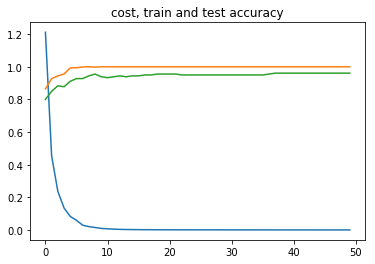

Final Train Accuracy: 1.0
Final Test Accuracy: 0.961111


In [19]:
path_f = "para_Bijie_Qiu.dat"
tf.reset_default_graph()
#def training(parameters, learningRate = 0.01, epochs = 20, mini_batch_size = 100)
with tf.Session() as sess:
    paras = initialization(42)
    #_, _, parameters = training(paras, epochs = 100, mini_batch_size = 20) #learningRate = 0.1,  epoch 25: 95
    #_, _, parameters = training(paras, epochs = 50, learning_Rate = 0.001, mini_batch_size = 30)  #epoch is 20 gives 96.67

   # _, _, parameters = training(paras,learning_Rate = 0.001, epochs = 20, mini_batch_size = 30) #epoch is 20 gives 94.44
    _, _, parameters = training(paras,learning_Rate = 0.001, epochs = 50, mini_batch_size = 10) #epoch is 8 gives 94.44

    #print(parameters)
        

In [1]:
#see photo for architecture

In [18]:
print(tf.__version__)

1.1.0
